In [1]:
import importlib
import frengression
# importlib.reload(frengression)
from data_causl.data_causl import *
from frengression import *
device = torch.device('cpu')

import numpy as np
import jax.numpy as jnp
import pickle
import os
from tqdm import tqdm
# import src.exp_utils as exp_utils

from matplotlib import pyplot as plt


np.random.seed(2024)
n_tr = 1000
n_p = 1000

nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
ate = 2
beta_cov = 0
strength_instr = 1
strength_conf = 1
strength_outcome = 1
binary_intervention=True


# Evaluate Y|do(X)
We mainly compare causal margin under binary treatments. P0, P1 store Ys sampled from fitted frengression under control and treatment, respectively. Q0, Q1 store Ys sampled from true Y|do(X) under control and treatment, respectively.

## when training size = 1000

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 0.9717, loss1 1.0134, loss2 0.0835
Epoch 1: loss 2.2780,	loss_y 1.5010, 1.5249, 0.0477,	loss_eta 0.7770, 0.8183, 0.0827


 10%|█         | 1/10 [00:13<02:01, 13.50s/it]

Epoch 1: loss 0.9504, loss1 1.0139, loss2 0.1270
Epoch 1: loss 2.2286,	loss_y 1.4909, 1.5154, 0.0492,	loss_eta 0.7377, 0.7860, 0.0965


 20%|██        | 2/10 [00:26<01:45, 13.19s/it]

Epoch 1: loss 0.9567, loss1 0.9799, loss2 0.0463
Epoch 1: loss 2.1350,	loss_y 1.3850, 1.3990, 0.0281,	loss_eta 0.7500, 0.7894, 0.0787


 30%|███       | 3/10 [00:39<01:31, 13.08s/it]

Epoch 1: loss 0.9654, loss1 1.0030, loss2 0.0751
Epoch 1: loss 2.2312,	loss_y 1.4838, 1.5085, 0.0495,	loss_eta 0.7475, 0.7780, 0.0609


 40%|████      | 4/10 [00:52<01:18, 13.13s/it]

Epoch 1: loss 0.9423, loss1 0.9860, loss2 0.0874
Epoch 1: loss 2.2843,	loss_y 1.5381, 1.5488, 0.0215,	loss_eta 0.7462, 0.7763, 0.0601


 50%|█████     | 5/10 [01:06<01:07, 13.43s/it]

Epoch 1: loss 0.9838, loss1 1.0256, loss2 0.0835
Epoch 1: loss 2.3057,	loss_y 1.5406, 1.5544, 0.0277,	loss_eta 0.7651, 0.8009, 0.0716


 60%|██████    | 6/10 [01:19<00:53, 13.34s/it]

Epoch 1: loss 0.9588, loss1 0.9887, loss2 0.0599
Epoch 1: loss 2.2583,	loss_y 1.4562, 1.4823, 0.0522,	loss_eta 0.8021, 0.8242, 0.0443


 70%|███████   | 7/10 [01:33<00:40, 13.38s/it]

Epoch 1: loss 0.9553, loss1 0.9882, loss2 0.0658
Epoch 1: loss 2.2480,	loss_y 1.4645, 1.5038, 0.0786,	loss_eta 0.7835, 0.8055, 0.0439


 80%|████████  | 8/10 [01:47<00:27, 13.67s/it]

Epoch 1: loss 0.9604, loss1 1.0215, loss2 0.1222
Epoch 1: loss 2.2454,	loss_y 1.4648, 1.4864, 0.0433,	loss_eta 0.7806, 0.8142, 0.0673


 90%|█████████ | 9/10 [02:00<00:13, 13.49s/it]

Epoch 1: loss 0.9608, loss1 0.9963, loss2 0.0709
Epoch 1: loss 2.1685,	loss_y 1.4257, 1.4601, 0.0687,	loss_eta 0.7428, 0.7817, 0.0778


100%|██████████| 10/10 [02:13<00:00, 13.37s/it]

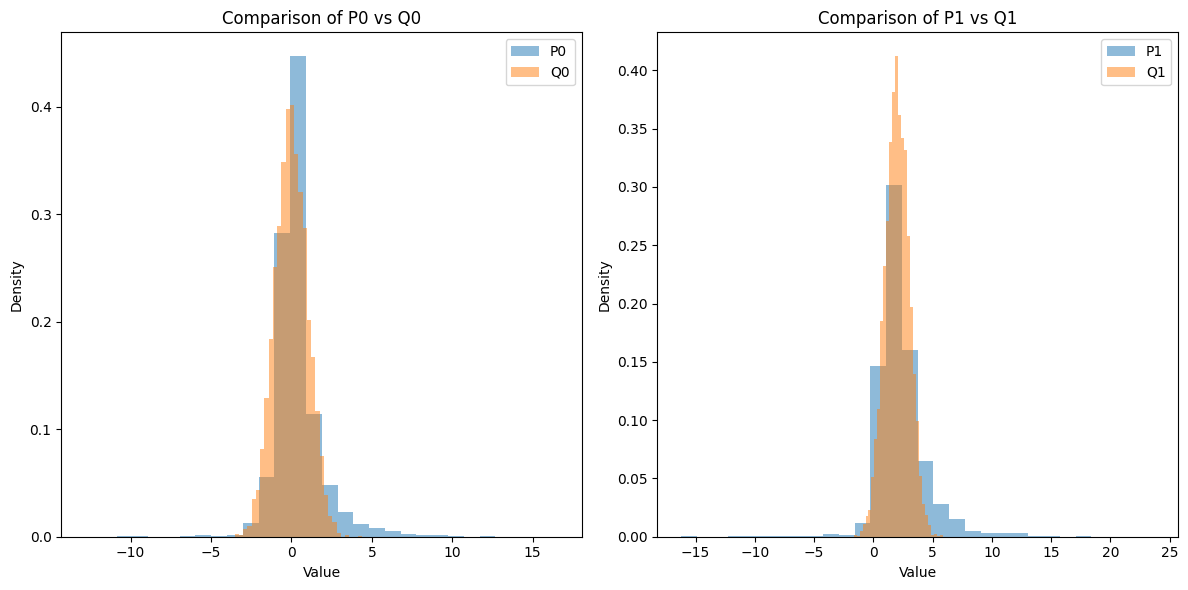

In [2]:
nrep = 10 # for equivalence testing
n_tr = 1000
n_p = 500
# Initialize an empty list to store each Q_single
nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
binary_intervention=True

# Initialize an empty list to store each Q_single
P0_list = []
Q0_list = []
P1_list = []
Q1_list = []
for _ in tqdm(range(nrep)):
    df_tr = generate_data_causl(n=n_tr, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)

    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    if binary_intervention:
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
    else:
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)

    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=400, device=device, x_binary = binary_intervention)
    model.train_xz(x_tr, z_tr, num_iters=500, print_every_iter=2000)
    model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-4, print_every_iter=2000)

    # sample from causal marginal distribution
    Q0_single= np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p,1])
    Q0_list.append(Q0_single)
    Q1_single= np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p,1])
    Q1_list.append(Q1_single)


    P0_single = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1,1)
    P0_list.append(P0_single)
    P1_single = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1,1)
    P1_list.append(P1_single)
  

P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
Q0s = np.stack(Q0_list, axis=0)
P1s = np.stack(P1_list, axis=0)
Q1s = np.stack(Q1_list, axis=0)


# Create histograms with overlapping bars
plt.figure(figsize=(12, 6))

# Plot P0 vs Q0
plt.subplot(1, 2, 1)
plt.hist(P0s.reshape(-1), bins=30, alpha=0.5, label='P0', density=True)
plt.hist(Q0s.reshape(-1), bins=30, alpha=0.5, label='Q0', density=True)
plt.title('Comparison of P0 vs Q0')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plot P1 vs Q1
plt.subplot(1, 2, 2)
plt.hist(P1s.reshape(-1), bins=30, alpha=0.5, label='P1', density=True)
plt.hist(Q1s.reshape(-1), bins=30, alpha=0.5, label='Q1', density=True)
plt.title('Comparison of P1 vs Q1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

## when training size = 500

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 0.9571, loss1 0.9910, loss2 0.0678
Epoch 1: loss 2.2344,	loss_y 1.4474, 1.4700, 0.0451,	loss_eta 0.7870, 0.8259, 0.0778


 10%|█         | 1/10 [00:07<01:07,  7.52s/it]

Epoch 1: loss 0.9749, loss1 1.0057, loss2 0.0616
Epoch 1: loss 2.3208,	loss_y 1.5432, 1.5755, 0.0647,	loss_eta 0.7776, 0.8193, 0.0833


 20%|██        | 2/10 [00:14<00:59,  7.41s/it]

Epoch 1: loss 0.9488, loss1 0.9898, loss2 0.0819
Epoch 1: loss 2.1836,	loss_y 1.4341, 1.4527, 0.0371,	loss_eta 0.7495, 0.7690, 0.0389


 30%|███       | 3/10 [00:22<00:51,  7.36s/it]

Epoch 1: loss 0.9676, loss1 1.0209, loss2 0.1067
Epoch 1: loss 2.2429,	loss_y 1.4282, 1.4419, 0.0273,	loss_eta 0.8148, 0.8396, 0.0497


 40%|████      | 4/10 [00:29<00:44,  7.34s/it]

Epoch 1: loss 0.9724, loss1 1.0090, loss2 0.0731
Epoch 1: loss 2.2105,	loss_y 1.4304, 1.4402, 0.0197,	loss_eta 0.7801, 0.8100, 0.0598


 50%|█████     | 5/10 [00:36<00:36,  7.35s/it]

Epoch 1: loss 0.9904, loss1 1.0297, loss2 0.0787
Epoch 1: loss 2.2355,	loss_y 1.4927, 1.4994, 0.0134,	loss_eta 0.7429, 0.7780, 0.0703


 60%|██████    | 6/10 [00:44<00:29,  7.33s/it]

Epoch 1: loss 0.9773, loss1 1.0053, loss2 0.0560
Epoch 1: loss 2.2588,	loss_y 1.4525, 1.4765, 0.0481,	loss_eta 0.8063, 0.8413, 0.0701


 70%|███████   | 7/10 [00:51<00:21,  7.32s/it]

Epoch 1: loss 0.9687, loss1 1.0205, loss2 0.1037
Epoch 1: loss 2.2662,	loss_y 1.5171, 1.5293, 0.0245,	loss_eta 0.7492, 0.7859, 0.0734


 80%|████████  | 8/10 [00:58<00:14,  7.30s/it]

Epoch 1: loss 0.9809, loss1 1.0116, loss2 0.0614
Epoch 1: loss 2.4857,	loss_y 1.6921, 1.7215, 0.0587,	loss_eta 0.7936, 0.8067, 0.0263


 90%|█████████ | 9/10 [01:05<00:07,  7.31s/it]

Epoch 1: loss 1.0093, loss1 1.0475, loss2 0.0765
Epoch 1: loss 2.3309,	loss_y 1.5628, 1.5757, 0.0257,	loss_eta 0.7681, 0.7964, 0.0566


100%|██████████| 10/10 [01:13<00:00,  7.32s/it]

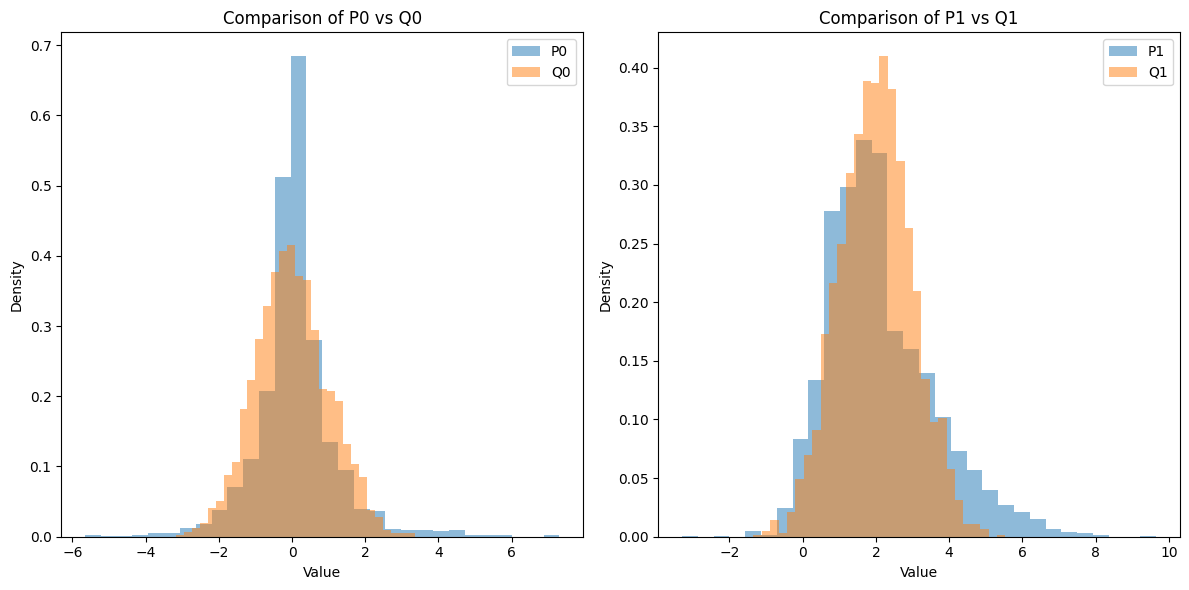

In [3]:
nrep = 10 # for equivalence testing
n_tr = 500
n_p = 250
# Initialize an empty list to store each Q_single
nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
binary_intervention=True

# Initialize an empty list to store each Q_single
P0_list = []
Q0_list = []
P1_list = []
Q1_list = []
for _ in tqdm(range(nrep)):
    df_tr = generate_data_causl(n=n_tr, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)

    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    if binary_intervention:
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
    else:
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)

    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=400, device=device, x_binary = binary_intervention)
    model.train_xz(x_tr, z_tr, num_iters=500, print_every_iter=2000)
    model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-4, print_every_iter=2000)

    # sample from causal marginal distribution
    Q0_single= np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p,1])
    Q0_list.append(Q0_single)
    Q1_single= np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p,1])
    Q1_list.append(Q1_single)


    P0_single = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1,1)
    P0_list.append(P0_single)
    P1_single = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1,1)
    P1_list.append(P1_single)
  

P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
Q0s = np.stack(Q0_list, axis=0)
P1s = np.stack(P1_list, axis=0)
Q1s = np.stack(Q1_list, axis=0)


# Create histograms with overlapping bars
plt.figure(figsize=(12, 6))

# Plot P0 vs Q0
plt.subplot(1, 2, 1)
plt.hist(P0s.reshape(-1), bins=30, alpha=0.5, label='P0', density=True)
plt.hist(Q0s.reshape(-1), bins=30, alpha=0.5, label='Q0', density=True)
plt.title('Comparison of P0 vs Q0')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plot P1 vs Q1
plt.subplot(1, 2, 2)
plt.hist(P1s.reshape(-1), bins=30, alpha=0.5, label='P1', density=True)
plt.hist(Q1s.reshape(-1), bins=30, alpha=0.5, label='Q1', density=True)
plt.title('Comparison of P1 vs Q1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

## when training size = 1000, but introducing intrumental / prognostic / spurious variables

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 1.8711, loss1 1.9592, loss2 0.1762
Epoch 1: loss 2.3093,	loss_y 1.5533, 1.6001, 0.0935,	loss_eta 0.7560, 0.7800, 0.0480


 10%|█         | 1/10 [00:13<01:57, 13.10s/it]

Epoch 1: loss 1.9017, loss1 1.9980, loss2 0.1925
Epoch 1: loss 2.3307,	loss_y 1.5045, 1.5183, 0.0276,	loss_eta 0.8262, 0.8672, 0.0820


 20%|██        | 2/10 [00:25<01:43, 12.97s/it]

Epoch 1: loss 1.8391, loss1 1.9351, loss2 0.1920
Epoch 1: loss 2.3294,	loss_y 1.5900, 1.6130, 0.0461,	loss_eta 0.7394, 0.7890, 0.0991


 30%|███       | 3/10 [00:38<01:30, 12.88s/it]

Epoch 1: loss 1.8501, loss1 1.9462, loss2 0.1924
Epoch 1: loss 2.3219,	loss_y 1.5412, 1.5614, 0.0404,	loss_eta 0.7807, 0.8177, 0.0740


 40%|████      | 4/10 [00:51<01:16, 12.79s/it]

Epoch 1: loss 1.8752, loss1 1.9856, loss2 0.2207
Epoch 1: loss 2.3052,	loss_y 1.5466, 1.5588, 0.0244,	loss_eta 0.7586, 0.8026, 0.0878


 50%|█████     | 5/10 [01:03<01:03, 12.71s/it]

Epoch 1: loss 1.8312, loss1 1.9153, loss2 0.1683
Epoch 1: loss 2.2997,	loss_y 1.5560, 1.5695, 0.0271,	loss_eta 0.7437, 0.7792, 0.0709


 60%|██████    | 6/10 [01:17<00:51, 12.97s/it]

Epoch 1: loss 1.8641, loss1 1.9609, loss2 0.1935
Epoch 1: loss 2.3145,	loss_y 1.5478, 1.5628, 0.0300,	loss_eta 0.7667, 0.7952, 0.0570


 70%|███████   | 7/10 [01:30<00:38, 12.88s/it]

Epoch 1: loss 1.8813, loss1 1.9603, loss2 0.1580
Epoch 1: loss 2.3024,	loss_y 1.5204, 1.5391, 0.0374,	loss_eta 0.7820, 0.8125, 0.0610


 80%|████████  | 8/10 [01:43<00:25, 12.98s/it]

Epoch 1: loss 1.8592, loss1 1.9636, loss2 0.2087
Epoch 1: loss 2.3191,	loss_y 1.5032, 1.5219, 0.0373,	loss_eta 0.8159, 0.8430, 0.0541


 90%|█████████ | 9/10 [01:56<00:12, 12.91s/it]

Epoch 1: loss 1.9019, loss1 2.0055, loss2 0.2071
Epoch 1: loss 2.3362,	loss_y 1.5663, 1.5873, 0.0422,	loss_eta 0.7700, 0.8126, 0.0852


100%|██████████| 10/10 [02:08<00:00, 12.88s/it]

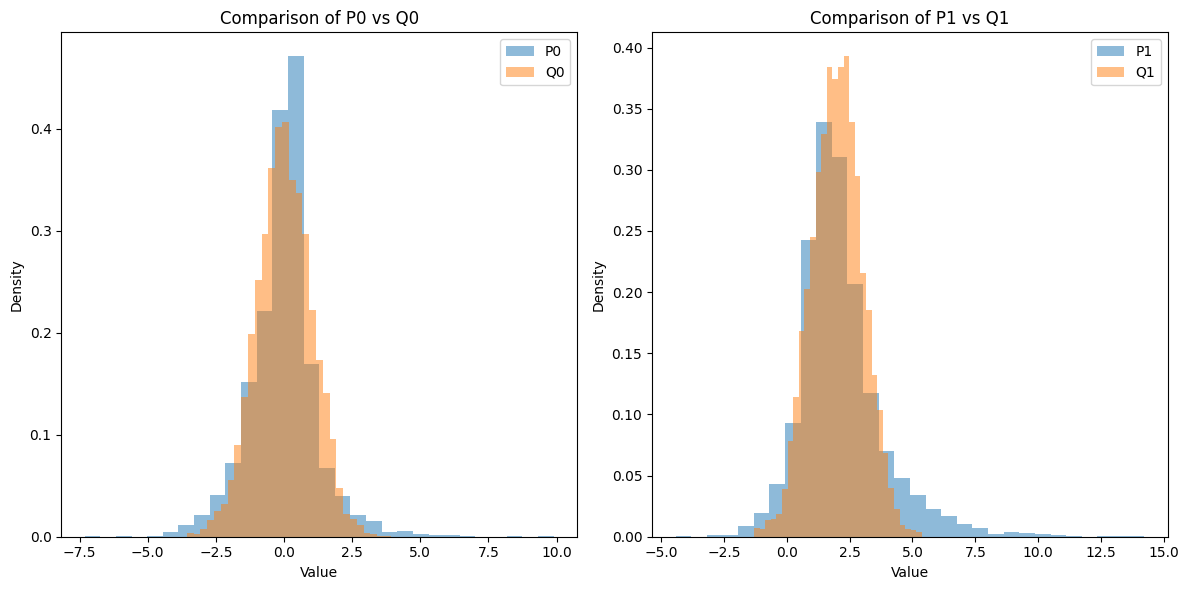

In [4]:
nrep = 10 # for equivalence testing
n_tr = 1000
n_p = 500
# Initialize an empty list to store each Q_single
nI = 1
nX = 1
nO = 1
nS= 1
p = nI+nX+nO+nS
binary_intervention=True

# Initialize an empty list to store each Q_single
P0_list = []
Q0_list = []
P1_list = []
Q1_list = []
for _ in tqdm(range(nrep)):
    df_tr = generate_data_causl(n=n_tr, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)

    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    if binary_intervention:
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
    else:
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)

    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=400, device=device, x_binary = binary_intervention)
    model.train_xz(x_tr, z_tr, num_iters=500, print_every_iter=2000)
    model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-4, print_every_iter=2000)

    # sample from causal marginal distribution
    Q0_single= np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p,1])
    Q0_list.append(Q0_single)
    Q1_single= np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p,1])
    Q1_list.append(Q1_single)


    P0_single = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1,1)
    P0_list.append(P0_single)
    P1_single = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1,1)
    P1_list.append(P1_single)
  

P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
Q0s = np.stack(Q0_list, axis=0)
P1s = np.stack(P1_list, axis=0)
Q1s = np.stack(Q1_list, axis=0)


# Create histograms with overlapping bars
plt.figure(figsize=(12, 6))

# Plot P0 vs Q0
plt.subplot(1, 2, 1)
plt.hist(P0s.reshape(-1), bins=30, alpha=0.5, label='P0', density=True)
plt.hist(Q0s.reshape(-1), bins=30, alpha=0.5, label='Q0', density=True)
plt.title('Comparison of P0 vs Q0')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plot P1 vs Q1
plt.subplot(1, 2, 2)
plt.hist(P1s.reshape(-1), bins=30, alpha=0.5, label='P1', density=True)
plt.hist(Q1s.reshape(-1), bins=30, alpha=0.5, label='Q1', density=True)
plt.title('Comparison of P1 vs Q1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()